[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/map-reduce.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239947-lesson-3-map-reduce)

# Map-reduce

## Review

We're building up to a multi-agent research assistant that ties together all of the modules from this course.

To build this multi-agent assistant, we've been introducing a few LangGraph controllability topics.

We just covered parallelization and sub-graphs.

## Goals

Now, we're going to cover [map reduce](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/).

In [ ]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [2]:

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Problem

Map-reduce operations are essential for efficient task decomposition and parallel processing. 

It has two phases:

(1) `Map` - Break a task into smaller sub-tasks, processing each sub-task in parallel.

(2) `Reduce` - Aggregate the results across all of the completed, parallelized sub-tasks.

Let's design a system that will do two things:

(1) `Map` - Create a set of jokes about a topic.

(2) `Reduce` - Pick the best joke from the list.

We'll use an LLM to do the job generation and selection.

In [68]:
from langchain_openai import ChatOpenAI

# Prompts we will use
subjects_prompt = """for a given {topic} classify this into 3 subjects"""
fact_prompt = """Generate a intresting fact about {subject}"""
best_fact_prompt = """Below are a bunch of facts about {topic}. Select the best one! Return the ID of the best one, starting 0 as the ID for the first fact. Facts: \n\n  {facts}"""

# LLM
model = ChatOpenAI(model="gpt-4o", temperature=0,api_key=os.getenv("GITHUB_TOKEN"),base_url="https://models.inference.ai.azure.com")

## State

### Parallelizing joke generation

First, let's define the entry point of the graph that will:

* Take a user input topic
* Produce a list of joke topics from it
* Send each joke topic to our above joke generation node

Our state has a `jokes` key, which will accumulate jokes from parallelized joke generation

In [69]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel

class Subjects(BaseModel):
    subjects: list[str]

class BestFact(BaseModel):
    id: int
    
class OverallState(TypedDict):
    topic: str
    subjects: list
    facts: Annotated[list, operator.add]
    best_selected_fact: str

Generate subjects for jokes.

In [70]:
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    print(response)
    return {"subjects": response.subjects}

Here is the magic: we use the [Send](https://langchain-ai.github.io/langgraph/concepts/low_level/#send) to create a joke for each subject.

This is very useful! It can automatically parallelize joke generation for any number of subjects.

* `generate_joke`: the name of the node in the graph
* `{"subject": s`}: the state to send

`Send` allow you to pass any state that you want to `generate_joke`! It does not have to align with `OverallState`.

In this case, `generate_joke` is using its own internal state, and we can popular this via `Send`.

In [71]:
from langgraph.constants import Send
def continue_to_facts(state: OverallState):
    return [Send("generate_fact", {"subject": s}) for s in state["subjects"]]

### Joke generation (map)

Now, we just define a node that will create our jokes, `generate_joke`!

We write them back out to `jokes` in `OverallState`! 

This key has a reducer that will combine lists.

In [72]:
class FactState(TypedDict):
    subject: str

class Fact(BaseModel):
    fact: str

def generate_fact(state: FactState):
    print(state["subject"])
    prompt = fact_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Fact).invoke(prompt)
    return {"facts": [response.fact]}

### Best joke selection (reduce)

Now, we add logic to pick the best joke.

In [73]:
def best_fact(state: OverallState):
    facts = "\n\n".join(state["facts"])
    prompt = best_fact_prompt.format(topic=state["topic"], facts=facts)
    response = model.with_structured_output(BestFact).invoke(prompt)
    return {"best_selected_fact": state["facts"][response.id]}

## Compile

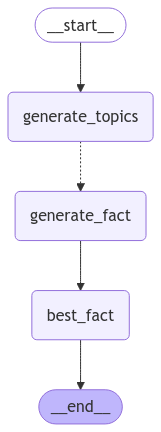

In [74]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_fact", generate_fact)
graph.add_node("best_fact", best_fact)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_facts, ["generate_fact"])
graph.add_edge("generate_fact", "best_fact")
graph.add_edge("best_fact", END)

# Compile the graph
app = graph.compile()
Image(app.get_graph().draw_mermaid_png())

In [77]:
# Call the graph: here we call it to generate a list of jokes
for s in app.stream({"topic": "technology"}):
    print(s)

subjects=['Technology']
{'generate_topics': {'subjects': ['Technology']}}
Technology
{'generate_fact': {'facts': ["The first computer virus, called 'Creeper,' was created in 1971 as an experimental self-replicating program. It displayed the message 'I'm the creeper, catch me if you can!' and was not designed to cause harm."]}}


RateLimitError: Error code: 429 - {'error': {'code': 'RateLimitReached', 'message': 'Rate limit of 50 per 86400s exceeded for UserByModelByDay. Please wait 85097 seconds before retrying.', 'details': 'Rate limit of 50 per 86400s exceeded for UserByModelByDay. Please wait 85097 seconds before retrying.'}}

## Studio

--

**⚠️ DISCLAIMER**

*Running Studio currently requires a Mac. If you are not using a Mac, then skip this step.*

*Also, if you are running this notebook in CoLab, then skip this step.*

--

Let's load our the above graph in the Studio UI, which uses `module-4/studio/map_reduce.py` set in `module-4/studio/langgraph.json`.

![Screenshot 2024-08-28 at 3.17.53 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb0c0ed88a12e822811e2_map-reduce1.png)